In [41]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE

In [42]:
def util_map(is_malignant):
    if is_malignant:
        return 1
    else:
        return 0

total = pd.read_csv('data/ddi_metadata.csv')
total['aux'] = total['malignant'].map(util_map)
skin_tones = {}
skin_tones[12] = total.query('skin_tone == 12')
skin_tones[34] = total.query('skin_tone == 34')
skin_tones[56] = total.query('skin_tone == 56')

In [43]:
def extract_histograms(image, bins=32):
    features = []
    
    for i in range(image.shape[2]):
        hist = cv2.calcHist([image], [i], None, [bins], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        features.extend(hist)
    return features

def extract_mean_std(image):
    means = np.mean(image, axis=(0, 1))
    stds = np.std(image, axis=(0, 1))
    return np.concatenate([means, stds])

def extract_color_space_features(image_path):
    full_features = []

    image = cv2.imread(image_path)
    image = cv2.resize(image, (256, 256))

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # RGB
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) # HSV
    image_ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb) # YCbCr

    full_features.extend(extract_histograms(image_rgb))
    full_features.extend(extract_mean_std(image_rgb))

    full_features.extend(extract_histograms(image_hsv))
    full_features.extend(extract_mean_std(image_hsv))

    full_features.extend(extract_histograms(image_ycbcr))

    return np.array(full_features)
    full_features.extend(extract_mean_std(image_ycbcr))

    return np.array(full_features)

In [44]:
def predict_all(df, loops=100):
    features = []
    labels = []

    for row in df.to_dict(orient='records'):
        features.append(extract_color_space_features(f'data/{row['DDI_file']}'))
        labels.append(row['aux'])

    X = np.array(features)
    y = np.array(labels)
    
    general_accuracy = 0
    general_precision = 0
    general_confusion_matrix = np.zeros((2, 2), dtype=float)

    for i in tqdm(range(loops)):
        pca = PCA(n_components=60)
        X_pca = pca.fit_transform(X)

        sm = SMOTE()
        X_resampled, y_resampled = sm.fit_resample(X_pca, y)

        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

        clf = RandomForestClassifier(n_estimators=100)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)
        #print(classification_report(y_test, y_pred))
        general_confusion_matrix += confusion_matrix(y_test, y_pred, labels=[0, 1])

        general_accuracy += accuracy_score(y_test, y_pred)
        general_precision += precision_score(y_test, y_pred, average='macro')

    general_accuracy = general_accuracy/loops
    general_precision = general_precision/loops

    print('\n---------------------------------------------------')
    print(f'General Accuracy = {general_accuracy}')
    print(f'General Precision = {general_precision}')

    
    return general_confusion_matrix/loops

100%|██████████| 100/100 [00:40<00:00,  2.44it/s]


---------------------------------------------------
General Accuracy = 0.8571134020618554
General Precision = 0.8575809549682841


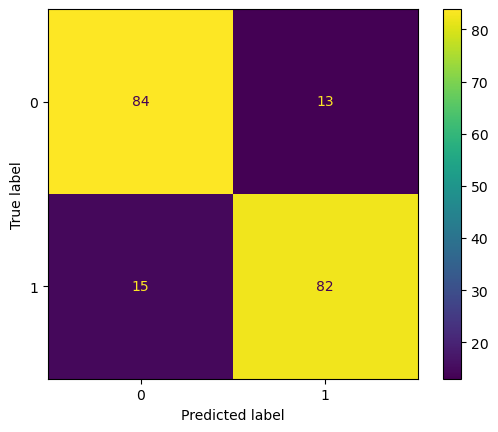

In [45]:
cm = predict_all(total)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

100%|██████████| 100/100 [00:13<00:00,  7.48it/s]



---------------------------------------------------
General Accuracy = 0.898125
General Precision = 0.8979181855178004


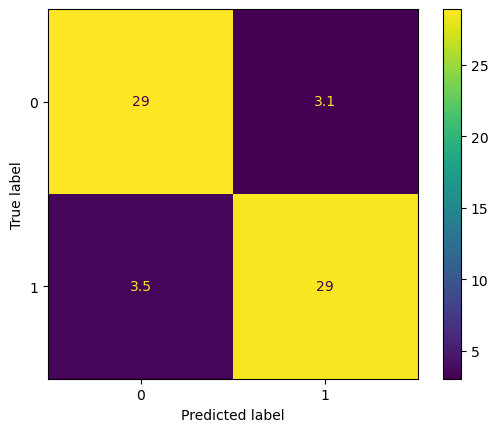

In [46]:
cm = predict_all(skin_tones[12])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

100%|██████████| 100/100 [00:14<00:00,  6.75it/s]



---------------------------------------------------
General Accuracy = 0.8325373134328358
General Precision = 0.8349590579252097


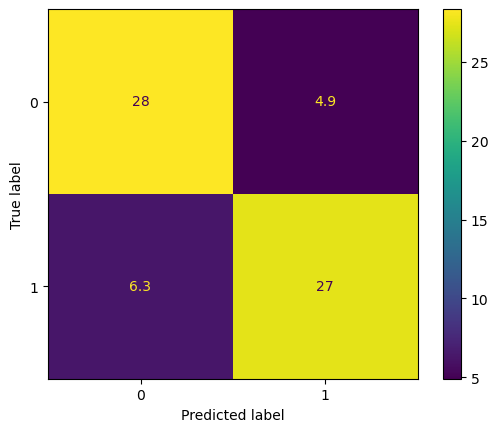

In [47]:
cm = predict_all(skin_tones[34])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()

100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


---------------------------------------------------
General Accuracy = 0.900625
General Precision = 0.9021405008969207


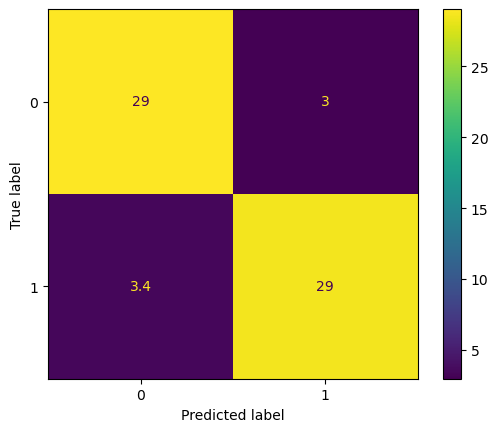

In [48]:
cm = predict_all(skin_tones[56])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()